https://discourse.julialang.org/t/solving-difference-equation-part-2/67057

In [1]:
using DynamicalSystems, DelimitedFiles, .Threads,  BenchmarkTools, ProgressMeter
## Components of a test DiscreteDynamicalSystem

function dds_constructor(u0 = [0.5, 0.7];  r=1.0, k=2.0)
    return DiscreteDynamicalSystem(dds_rule, u0, [r, k], dds_jac)
end
## equations of motion:
function dds_rule(x, par, n)
   r, k = par
   a, mu, d = 5.0, 0.5, 0.2
   dx = x[1]*exp(r*(1-x[1]/k)-x[2]/(a+x[1]^2))
   dy = x[2]*exp(mu*x[1]/(a+x[1]^2)-d)
   return @SVector [dx, dy]
end
## Jacobian:
function dds_jac(x, par, n)
    r, k = par;
    a = 5.0; mu = 0.5; d = 0.2;
    J11 = exp(- x[2]/(x[1]^2 + a) - r*(x[1]/k - 1)) - x[1]*exp(- x[2]/(x[1]^2 + a) - r*(x[1]/k - 1))*(r/k - (2*x[1]*x[2])/(x[1]^2 + a)^2)
    J12 = -(x[1]*exp(- x[2]/(x[1]^2 + a) - r*(x[1]/k - 1)))/(x[1]^2 + a)
    J21 = x[2]*exp((mu*x[1])/(x[1]^2 + a) - d)*(mu/(x[1]^2 + a) - (2*mu*x[1]^2)/(x[1]^2 + a)^2)
    J22 = exp((mu*x[1])/(x[1]^2 + a) - d)
    return @SMatrix [J11  J12; J21 J22]
end

dds_jac (generic function with 1 method)

In [2]:
function traj!(tr, f, p, x0, T; Ttr=0)
    x = x0
    for i in 1:Ttr
        x = f(x, p, i-1)
    end
    @inbounds tr[1] = x
    for i in 1:T
        @inbounds tr[i+1] = f(tr[i], p, Ttr+i-1)
    end
    tr
end

traj! (generic function with 1 method)

In [3]:
function traj2d!(tr1, tr2, f, p, x0, T; Ttr=0)
    x = x0
    for i in 1:Ttr
        x = f(x, p, i-1)
    end
    @inbounds tr1[1], tr2[1] = x
    for i in 1:T
        @inbounds tr1[i+1], tr2[i+1] = f((tr1[i], tr2[i]), p, Ttr+i-1)
    end
    tr1, tr2
end

traj2d! (generic function with 1 method)

In [4]:
traj2d!(zeros(21), zeros(21), ((a, b), p, t) -> (b, a+b), nothing, (0, 1), 20)

([0.0, 1.0, 1.0, 2.0, 3.0, 5.0, 8.0, 13.0, 21.0, 34.0  …  89.0, 144.0, 233.0, 377.0, 610.0, 987.0, 1597.0, 2584.0, 4181.0, 6765.0], [1.0, 1.0, 2.0, 3.0, 5.0, 8.0, 13.0, 21.0, 34.0, 55.0  …  144.0, 233.0, 377.0, 610.0, 987.0, 1597.0, 2584.0, 4181.0, 6765.0, 10946.0])

In [20]:
function seqper_new(x; tol=1e-3)       # function to calculate periodicity
    n = length(x)
    @inbounds for k in 2:(n ÷ 2 + 1)
        if abs(x[k] - x[1]) ≤ tol
            all(j -> abs(x[j] - x[j-k+1]) ≤ tol, k:n) && return k - 1
        end
    end 
    return n
end

seqper_new (generic function with 1 method)

In [6]:
function meshh(x,y)    # create a meshgrid of x and y
    len_x = length(x);
    len_y = length(y);
    xmesh = Float64[]
    ymesh = Float64[]
    for i in 1:len_x
        for j in 1:len_y
            push!(xmesh, x[i])
            push!(ymesh, y[j])
        end
    end
    return  xmesh, ymesh 
end

x = 1:3
y = 1:4
@show meshh(x, y)
meshh(x, y) .== vec.(reim(complex.(x', y)))

meshh(x, y) = ([1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0], [1.0, 2.0, 3.0, 4.0, 1.0, 2.0, 3.0, 4.0, 1.0, 2.0, 3.0, 4.0])


(true, true)

In [7]:
function meshh!(xmesh, ymesh, x, y)    # create a meshgrid of x and y
    len_x, len_y = length(x), length(y)
    for i in 1:len_x
        for j in 1:len_y
            xmesh[len_y*(i-1) + j] = x[i]
            ymesh[len_y*(i-1) + j] = y[j]
        end
    end
end

x = 1:3
y = 1:4
xmesh = Vector{Float64}(undef, length(x)*length(y))
ymesh = Vector{Float64}(undef, length(x)*length(y))
meshh!(xmesh, ymesh, x, y)
@show xmesh, ymesh
meshh(x, y) .== (xmesh, ymesh)

(xmesh, ymesh) = ([1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0], [1.0, 2.0, 3.0, 4.0, 1.0, 2.0, 3.0, 4.0, 1.0, 2.0, 3.0, 4.0])


(true, true)

In [8]:
function isoperiodic_test_org(ds, par_area::Matrix{Float64}, NIter::Int64,
                         nxblock::Int64, nyblock::Int64, NTr::Int64, xpts::Int64, ypts::Int64)    

    p1_st =  par_area[1];          # beginning of first parameter 
    p1_nd =  par_area[2];          # end of first parameter
    p2_st =  par_area[3];          # beginning of second parameter
    p2_nd =  par_area[4];          # end of second parameter

    p1_block = range(p1_st, p1_nd, length=nxblock + 1);    # divide par_area in blocks 
    p2_block = range(p2_st, p2_nd, length=nyblock + 1);    # divide par_area in blocks 
    l_bipar = xpts * ypts;                                 # total number of pts in each block
    total_blocks = nxblock * nyblock                       # total number of blocks
    sol_last = Array{Float64,2}(undef, NIter + 1, l_bipar);   # stores x values of solution for l_bipar (r,k) paris

    dss = [deepcopy(ds) for _ in 1:nthreads()]
    periods = Vector{Int}(undef, l_bipar * total_blocks)
    par1mesh = Vector{Float64}(undef, l_bipar * total_blocks)
    par2mesh = Vector{Float64}(undef, l_bipar * total_blocks)
    prog = Progress(total_blocks)
    for ii in 1:nxblock
        par1range = range(p1_block[ii], p1_block[ii+1], length=xpts+1)[1:end-1]
        for jj in 1:nyblock
            par2range = range(p2_block[jj], p2_block[jj+1], length=ypts+1)[1:end-1]
            Threads.@threads for i = 1:xpts         
                tid = threadid()
                for j = 1:ypts
                     set_parameter!(dss[tid], [par1range[i], par2range[j]]) # change the parameter values
                     tr = trajectory(dss[tid], NIter; Ttr=NTr)              # find the solution
                     sol_last[:, ypts*(i-1)+j] = tr[:,1]                    # store x-values
                end
            end
            a = l_bipar*(nyblock*(ii-1)+jj-1)
            periods[a+1:a+l_bipar] = seqper_new.(eachcol(sol_last), tol=0.001) # seqper_new calculates periodicity
            par1mesh[a+1:a+l_bipar], par2mesh[a+1:a+l_bipar] = meshh(par1range, par2range) # meshgrid of parameter values
            next!(prog)
        end
    end
    par1mesh, par2mesh, periods
end

isoperiodic_test_org (generic function with 1 method)

In [9]:
function isoperiodic_test_rev1(ds, par_area, NIter, nxblock, nyblock, NTr, xpts, ypts)    

    p1_st = par_area[1]          # beginning of first parameter 
    p1_nd = par_area[2]          # end of first parameter
    p2_st = par_area[3]          # beginning of second parameter
    p2_nd = par_area[4]          # end of second parameter

    p1_block = range(p1_st, p1_nd, length = nxblock + 1)   # divide par_area in blocks 
    p2_block = range(p2_st, p2_nd, length = nyblock + 1)   # divide par_area in blocks 
    l_bipar = xpts * ypts                                  # total number of pts in each block
    total_blocks = nxblock * nyblock                       # total number of blocks
    sol_last = Matrix{Float64}(undef, NIter + 1, l_bipar)  # stores x values of solution for l_bipar (r,k) paris

    param = [zeros(2) for _ in 1:nthreads()]
    dss = [deepcopy(ds) for _ in 1:nthreads()]
    periods = Vector{Int}(undef, l_bipar * total_blocks)
    par1mesh = Vector{Float64}(undef, l_bipar * total_blocks)
    par2mesh = Vector{Float64}(undef, l_bipar * total_blocks)
    prog = Progress(total_blocks)
    @inbounds for ii in 1:nxblock
        par1range = range(p1_block[ii], p1_block[ii+1], length=xpts+1)[1:end-1]
        for jj in 1:nyblock
            par2range = range(p2_block[jj], p2_block[jj+1], length=ypts+1)[1:end-1]
            Threads.@threads for i = 1:xpts
                tid = threadid()
                @inbounds for j = 1:ypts
                    param[tid] .= (par1range[i], par2range[j])
                    set_parameter!(dss[tid], param[tid])                    # change the parameter values
                    tr = trajectory(dss[tid], NIter; Ttr=NTr)                # find the solution
                    sol_last[:, ypts*(i-1)+j] .= first.(tr.data) # store x-values
                end
            end
            a = l_bipar*(nyblock*(ii-1)+jj-1)
            periods[a+1:a+l_bipar] .= seqper_new.(eachcol(sol_last), tol=0.001) # seqper_new calculates periodicity
            @views meshh!(par1mesh[a+1:a+l_bipar], par2mesh[a+1:a+l_bipar], par1range, par2range) # meshgrid of parameter values
            next!(prog)
        end
    end
    par1mesh, par2mesh, periods
end

isoperiodic_test_rev1 (generic function with 1 method)

In [10]:
function isoperiodic_test_rev2_old(init, par_area, NIter, nxblock, nyblock, NTr, xpts, ypts)
    u0 = SVector{2}(init)
    p1_st = par_area[1]          # beginning of first parameter 
    p1_nd = par_area[2]          # end of first parameter
    p2_st = par_area[3]          # beginning of second parameter
    p2_nd = par_area[4]          # end of second parameter

    p1_block = range(p1_st, p1_nd, length = nxblock + 1)   # divide par_area in blocks 
    p2_block = range(p2_st, p2_nd, length = nyblock + 1)   # divide par_area in blocks 
    l_bipar = xpts * ypts                                  # total number of pts in each block
    total_blocks = nxblock * nyblock                       # total number of blocks
    sol_last = Matrix{Float64}(undef, NIter + 1, l_bipar)  # stores x values of solution for l_bipar (r,k) paris

    periods = Vector{Int}(undef, l_bipar * total_blocks)
    par1mesh = Vector{Float64}(undef, l_bipar * total_blocks)
    par2mesh = Vector{Float64}(undef, l_bipar * total_blocks)
    tr = [Vector{SVector{2, Float64}}(undef, NIter + 1) for _ in 1:nthreads()]
    prog = Progress(total_blocks)
    @inbounds for ii in 1:nxblock
        par1range = range(p1_block[ii], p1_block[ii+1], length=xpts+1)[1:end-1]
        for jj in 1:nyblock
            par2range = range(p2_block[jj], p2_block[jj+1], length=ypts+1)[1:end-1]   
            Threads.@threads for i = 1:xpts
                tid = threadid()
                @inbounds for j = 1:ypts
                    traj!(tr[tid], dds_rule, (par1range[i], par2range[j]), u0, NIter; Ttr=NTr) # find the solution
                    sol_last[:, ypts*(i-1)+j] .= first.(tr[tid])   # store x-values
                end
            end
            a = l_bipar*(nyblock*(ii-1)+jj-1)
            periods[a+1:a+l_bipar] .= seqper_new.(eachcol(sol_last), tol=0.001) # seqper_new calculates periodicity
            @views meshh!(par1mesh[a+1:a+l_bipar], par2mesh[a+1:a+l_bipar], par1range, par2range) # meshgrid of parameter values
            next!(prog)
        end
    end
    par1mesh, par2mesh, periods
end

isoperiodic_test_rev2_old (generic function with 1 method)

In [11]:
function isoperiodic_test_rev2(init, par_area, NIter, nxblock, nyblock, NTr, xpts, ypts)
    u0 = SVector{2}(init)
    p1_st = par_area[1]          # beginning of first parameter 
    p1_nd = par_area[2]          # end of first parameter
    p2_st = par_area[3]          # beginning of second parameter
    p2_nd = par_area[4]          # end of second parameter

    p1_block = range(p1_st, p1_nd, length = nxblock + 1)   # divide par_area in blocks 
    p2_block = range(p2_st, p2_nd, length = nyblock + 1)   # divide par_area in blocks 
    l_bipar = xpts * ypts                                  # total number of pts in each block
    total_blocks = nxblock * nyblock                       # total number of blocks

    periods = Vector{Int}(undef, l_bipar * total_blocks)
    par1mesh = Vector{Float64}(undef, l_bipar * total_blocks)
    par2mesh = Vector{Float64}(undef, l_bipar * total_blocks)
    tr1 = [Vector{Float64}(undef, NIter + 1) for _ in 1:nthreads()]
    tr2 = [Vector{Float64}(undef, NIter + 1) for _ in 1:nthreads()]
    prog = Progress(total_blocks)
    @inbounds for ii in 1:nxblock
        par1range = range(p1_block[ii], p1_block[ii+1], length=xpts+1)[1:end-1]
        for jj in 1:nyblock
            par2range = range(p2_block[jj], p2_block[jj+1], length=ypts+1)[1:end-1]
            a = l_bipar*(nyblock*(ii-1)+jj-1)
            Threads.@threads for i = 1:xpts
                tid = threadid()
                @inbounds for j = 1:ypts
                    traj2d!(tr1[tid], tr2[tid], 
                        dds_rule, (par1range[i], par2range[j]), u0, NIter; Ttr=NTr) # find the solution
                    periods[a + ypts*(i-1)+j] = seqper_new(tr1[tid], tol=0.001)
                end
            end
            @views meshh!(par1mesh[a+1:a+l_bipar], par2mesh[a+1:a+l_bipar], par1range, par2range) # meshgrid of parameter values
            next!(prog)
        end 
    end
    par1mesh, par2mesh, periods
end

isoperiodic_test_rev2 (generic function with 1 method)

In [12]:
##  Test

parameter_area = [1.0 5.0 2.0 5.0]
nxblock = 1
nyblock = 1
xpts = 100
ypts = 100
NIter = 2000
NTr = 50000
init = [0.4, 0.5]
ds = dds_constructor(init)
##
println("********** Minor correction of the original:")
result_org = @time isoperiodic_test_org(ds, parameter_area, NIter, nxblock, nyblock, NTr, xpts, ypts)
result_org = @time isoperiodic_test_org(ds, parameter_area, NIter, nxblock, nyblock, NTr, xpts, ypts)
result_org = @time isoperiodic_test_org(ds, parameter_area, NIter, nxblock, nyblock, NTr, xpts, ypts)
println("********** Revised 1:")
result_rev1 = @time isoperiodic_test_rev1(ds, parameter_area, NIter, nxblock, nyblock, NTr, xpts, ypts)
result_rev1 = @time isoperiodic_test_rev1(ds, parameter_area, NIter, nxblock, nyblock, NTr, xpts, ypts)
result_rev1 = @time isoperiodic_test_rev1(ds, parameter_area, NIter, nxblock, nyblock, NTr, xpts, ypts)
println("********** Revised 2:")
result_rev2 = @time isoperiodic_test_rev2(init, parameter_area, NIter, nxblock, nyblock, NTr, xpts, ypts)
result_rev2 = @time isoperiodic_test_rev2(init, parameter_area, NIter, nxblock, nyblock, NTr, xpts, ypts)
result_rev2 = @time isoperiodic_test_rev2(init, parameter_area, NIter, nxblock, nyblock, NTr, xpts, ypts)
println("********** Confirmation of equivalence:")
@show result_org .== result_rev1;
@show result_rev1 .== result_rev2;

********** Minor correction of the original:
  7.323087 seconds (5.29 M allocations: 917.554 MiB, 1.87% gc time, 21.31% compilation time)
  5.840780 seconds (40.35 k allocations: 615.763 MiB, 1.96% gc time)
  6.056758 seconds (40.34 k allocations: 615.762 MiB, 5.73% gc time)
********** Revised 1:
  6.355134 seconds (1.01 M allocations: 515.935 MiB, 5.43% gc time, 2.54% compilation time)
  7.062599 seconds (20.34 k allocations: 459.852 MiB, 14.43% gc time)
  5.833955 seconds (20.33 k allocations: 459.852 MiB)
********** Revised 2:
  6.112252 seconds (348.90 k allocations: 20.618 MiB, 5.58% gc time, 8.12% compilation time)
  5.646109 seconds (243 allocations: 631.094 KiB)
  5.673156 seconds (242 allocations: 631.000 KiB)
********** Confirmation of equivalence:
result_org .== result_rev1 = (true, true, true)
result_rev1 .== result_rev2 = (true, true, true)


In [13]:
##  Test

parameter_area = [1.0 5.0 2.0 5.0]
nxblock = 2
nyblock = 2
xpts = 100
ypts = 100
NIter = 2000
NTr = 50000
init = [0.4, 0.5]
ds = dds_constructor(init)
##
println("********** Minor correction of the original:")
result_org = @time isoperiodic_test_org(ds, parameter_area, NIter, nxblock, nyblock, NTr, xpts, ypts)
result_org = @time isoperiodic_test_org(ds, parameter_area, NIter, nxblock, nyblock, NTr, xpts, ypts)
result_org = @time isoperiodic_test_org(ds, parameter_area, NIter, nxblock, nyblock, NTr, xpts, ypts)
println("********** Revised 1:")
result_rev1 = @time isoperiodic_test_rev1(ds, parameter_area, NIter, nxblock, nyblock, NTr, xpts, ypts)
result_rev1 = @time isoperiodic_test_rev1(ds, parameter_area, NIter, nxblock, nyblock, NTr, xpts, ypts)
result_rev1 = @time isoperiodic_test_rev1(ds, parameter_area, NIter, nxblock, nyblock, NTr, xpts, ypts)
println("********** Revised 2:")
result_rev2 = @time isoperiodic_test_rev2(init, parameter_area, NIter, nxblock, nyblock, NTr, xpts, ypts)
result_rev2 = @time isoperiodic_test_rev2(init, parameter_area, NIter, nxblock, nyblock, NTr, xpts, ypts)
result_rev2 = @time isoperiodic_test_rev2(init, parameter_area, NIter, nxblock, nyblock, NTr, xpts, ypts)
println("********** Confirmation of equivalence:")
@show result_org .== result_rev1;
@show result_rev1 .== result_rev2;

********** Minor correction of the original:


Progress: 100%|█████████████████████████████████████████| Time: 0:00:24


 24.701080 seconds (1.62 M allocations: 2.038 GiB, 8.72% gc time, 5.82% compilation time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:24


 24.753732 seconds (161.29 k allocations: 1.958 GiB, 10.33% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:24


 24.940760 seconds (161.19 k allocations: 1.958 GiB, 11.43% gc time)
********** Revised 1:


Progress: 100%|█████████████████████████████████████████| Time: 0:00:22


 22.423678 seconds (81.18 k allocations: 1.349 GiB, 1.30% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:23


 27.123860 seconds (81.20 k allocations: 1.349 GiB, 13.94% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:22


 26.537476 seconds (81.19 k allocations: 1.349 GiB, 14.02% gc time)
********** Revised 2:


Progress: 100%|█████████████████████████████████████████| Time: 0:00:23


 23.034039 seconds (967 allocations: 1.361 MiB)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:22


 22.717027 seconds (964 allocations: 1.361 MiB)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:22


 22.741629 seconds (1.08 k allocations: 1.370 MiB)
********** Confirmation of equivalence:
result_org .== result_rev1 = (true, true, true)
result_rev1 .== result_rev2 = (true, true, true)


In [14]:
##  Test

parameter_area = [1.0 5.0 2.0 5.0]
nxblock = 10
nyblock = 10
xpts = 10
ypts = 10
NIter = 2000
NTr = 50000
init = [0.4, 0.5]
ds = dds_constructor(init)
##
println("********** Minor correction of the original:")
result_org = @time isoperiodic_test_org(ds, parameter_area, NIter, nxblock, nyblock, NTr, xpts, ypts)
#result_org = @time isoperiodic_test_org(ds, parameter_area, NIter, nxblock, nyblock, NTr, xpts, ypts)
#result_org = @time isoperiodic_test_org(ds, parameter_area, NIter, nxblock, nyblock, NTr, xpts, ypts)
println("********** Revised 1:")
result_rev1 = @time isoperiodic_test_rev1(ds, parameter_area, NIter, nxblock, nyblock, NTr, xpts, ypts)
#result_rev1 = @time isoperiodic_test_rev1(ds, parameter_area, NIter, nxblock, nyblock, NTr, xpts, ypts)
#result_rev1 = @time isoperiodic_test_rev1(ds, parameter_area, NIter, nxblock, nyblock, NTr, xpts, ypts)
println("********** Revised 2:")
result_rev2 = @time isoperiodic_test_rev2(init, parameter_area, NIter, nxblock, nyblock, NTr, xpts, ypts)
#result_rev2 = @time isoperiodic_test_rev2(init, parameter_area, NIter, nxblock, nyblock, NTr, xpts, ypts)
#result_rev2 = @time isoperiodic_test_rev2(init, parameter_area, NIter, nxblock, nyblock, NTr, xpts, ypts)
println("********** Confirmation of equivalence:")
@show result_org .== result_rev1;
@show result_rev1 .== result_rev2;

********** Minor correction of the original:


Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


  7.400067 seconds (56.55 k allocations: 465.810 MiB)
********** Revised 1:


Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


  7.352206 seconds (34.92 k allocations: 309.951 MiB)
********** Revised 2:


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


 16.300040 seconds (13.54 k allocations: 1.759 MiB, 62.79% gc time)
********** Confirmation of equivalence:
result_org .== result_rev1 = (true, true, true)
result_rev1 .== result_rev2 = (true, true, true)


  2.848868 seconds (119 allocations: 499.812 KiB)


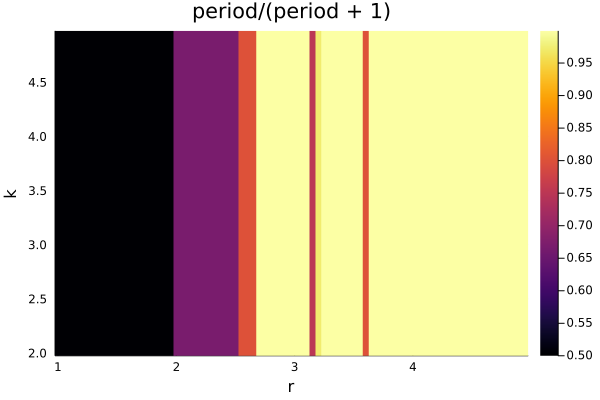

In [23]:
using Plots
xoxp1(x) = x/(x+1)

r, k, period = @time isoperiodic_test_rev2([0.4, 0.5], [1.0 5.0 2.0 5.0], 2000, 1, 1, 50000, 80, 60)
r = reshape(r, 60, 80)
k = reshape(k, 60, 80)
period = reshape(period, 60, 80)
heatmap(vec(r[1,:]), vec(k[:,1]), xoxp1.(period); xlabel="r", ylabel="k", title="period/(period + 1)")

In [22]:
@btime isoperiodic_test_rev2($([0.4, 0.5]), $([1.0 5.0 2.0 5.0]), 2000, 1, 1, 50000, 80, 60)

  2.653 s (117 allocations: 499.61 KiB)


([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  4.95, 4.95, 4.95, 4.95, 4.95, 4.95, 4.95, 4.95, 4.95, 4.95], [2.0, 2.05, 2.1, 2.15, 2.2, 2.25, 2.3, 2.35, 2.4, 2.45  …  4.5, 4.55, 4.6, 4.65, 4.7, 4.75, 4.8, 4.85, 4.9, 4.95], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  2001, 2001, 2001, 2001, 2001, 2001, 2001, 2001, 2001, 2001])

In [17]:
@code_warntype isoperiodic_test_org(ds, parameter_area, NIter, nxblock, nyblock, NTr, xpts, ypts)

Variables
  #self#::Core.Const(isoperiodic_test_org)
  ds::DiscreteDynamicalSystem{false, SVector{2, Float64}, 2, typeof(dds_rule), Vector{Float64}, typeof(dds_jac), SMatrix{2, 2, Float64, 4}, false}
  par_area::Matrix{Float64}
  NIter::Int64
  nxblock::Int64
  nyblock::Int64
  NTr::Int64
  xpts::Int64
  ypts::Int64
  @_10::Union{Nothing, Tuple{Int64, Int64}}
  #9::var"#9#10"{DiscreteDynamicalSystem{false, SVector{2, Float64}, 2, typeof(dds_rule), Vector{Float64}, typeof(dds_jac), SMatrix{2, 2, Float64, 4}, false}}
  prog::Progress
  par2mesh::Vector{Float64}
  par1mesh::Vector{Float64}
  periods::Vector{Int64}
  dss::Vector{DiscreteDynamicalSystem{false, SVector{2, Float64}, 2, typeof(dds_rule), Vector{Float64}, typeof(dds_jac), SMatrix{2, 2, Float64, 4}, false}}
  sol_last::Matrix{Float64}
  total_blocks::Int64
  l_bipar::Int64
  p2_block::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}
  p1_block::StepRangeLen{Float64, Base.TwicePrecision{Float64}, 

In [18]:
@code_warntype isoperiodic_test_rev1(ds, parameter_area, NIter, nxblock, nyblock, NTr, xpts, ypts)

Variables
  #self#::Core.Const(isoperiodic_test_rev1)
  ds::DiscreteDynamicalSystem{false, SVector{2, Float64}, 2, typeof(dds_rule), Vector{Float64}, typeof(dds_jac), SMatrix{2, 2, Float64, 4}, false}
  par_area::Matrix{Float64}
  NIter::Int64
  nxblock::Int64
  nyblock::Int64
  NTr::Int64
  xpts::Int64
  ypts::Int64
  @_10::Union{Nothing, Tuple{Int64, Int64}}
  val::Nothing
  #13::var"#13#15"{DiscreteDynamicalSystem{false, SVector{2, Float64}, 2, typeof(dds_rule), Vector{Float64}, typeof(dds_jac), SMatrix{2, 2, Float64, 4}, false}}
  #12::var"#12#14"
  prog::Progress
  par2mesh::Vector{Float64}
  par1mesh::Vector{Float64}
  periods::Vector{Int64}
  dss::Vector{DiscreteDynamicalSystem{false, SVector{2, Float64}, 2, typeof(dds_rule), Vector{Float64}, typeof(dds_jac), SMatrix{2, 2, Float64, 4}, false}}
  param::Vector{Vector{Float64}}
  sol_last::Matrix{Float64}
  total_blocks::Int64
  l_bipar::Int64
  p2_block::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Floa

In [19]:
@code_warntype isoperiodic_test_rev2(init, parameter_area, NIter, nxblock, nyblock, NTr, xpts, ypts)

Variables
  #self#::Core.Const(isoperiodic_test_rev2)
  init::Vector{Float64}
  par_area::Matrix{Float64}
  NIter::Int64
  nxblock::Int64
  nyblock::Int64
  NTr::Int64
  xpts::Int64
  ypts::Int64
  @_10::Union{Nothing, Tuple{Int64, Int64}}
  val::Nothing
  #21::var"#21#23"{Int64}
  #20::var"#20#22"{Int64}
  prog::Progress
  tr2::Vector{Vector{Float64}}
  tr1::Vector{Vector{Float64}}
  par2mesh::Vector{Float64}
  par1mesh::Vector{Float64}
  periods::Vector{Int64}
  total_blocks::Int64
  l_bipar::Int64
  p2_block::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}
  p1_block::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}
  p2_nd::Float64
  p2_st::Float64
  p1_nd::Float64
  p1_st::Float64
  u0::SVector{2, Float64}
  @_29::Union{Nothing, Tuple{Int64, Int64}}
  ii::Int64
  par1range::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}
  threadsfor_fun::var"#116#threadsfor_fun#24"{Int64, Int64, I